In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import sys
import geopandas as gpd
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform

In [2]:
import open_cp

## Assets

In [3]:
geojson_bogota_file="/Users/anamaria/Desktop/dev/security_project/assets/bogota_polygon.geojson"
geojson_localidad_file="/Users/anamaria/Desktop/dev/security_project/assets/localidades_polygon.json"

with open(geojson_bogota_file) as f:
    geojson_bogota = geojson.load(f)

with open(geojson_localidad_file) as f:
    geojson_localidad = geojson.load(f)

## Built-in

In [13]:
def rectangular_region_projection(polygon, inProj, outProj):
    minx, miny, maxx, maxy = polygon.bounds
    # swap x,y as mkennedy says
    y1,x1 =  (miny, minx)
    point1=transform(inProj,outProj,x1,y1)
    x1, y1 = point1

    y2,x2 = (maxy, maxx)
    point2 = transform(inProj,outProj,x2,y2)
    x2, y2 = point2
    
    shapely_polygon = Polygon([[x1,y1],[x2,y1],[x2,y2],[x1,y2]])
    opencp_rectangular = open_cp.RectangularRegion(xmin=x1, xmax=x2, ymin=y1, ymax=y2)
    
    return shapely_polygon, opencp_rectangular

## Rectangular region

In [14]:
list_coords =list(map(lambda x: tuple(x), geojson_bogota['features'][0]['geometry']['coordinates'][0]))
bogota_polygon = Polygon(list_coords)

In [15]:
inProj  = Proj("+init=EPSG:4326",preserve_units=True) # WGS84 in degrees and not EPSG:3857 in meters)
outProj = Proj("+init=EPSG:3116") 

In [16]:
shapely_rectangular, opencp_rectangular = rectangular_region_projection(bogota_polygon, inProj, outProj)
print(shapely_rectangular)
print(opencp_rectangular)

POLYGON ((958645.8182116302 904338.0678953262, 1010091.35096879 904338.0678953262, 1010091.35096879 1026604.284654521, 958645.8182116302 1026604.284654521, 958645.8182116302 904338.0678953262))
RectangularRegion( (958645.8182116302,904338.0678953262) -> (1010091.3509687895,1026604.2846545206) )


## City coverage on rectangular region

In [20]:
inProj  = Proj("+init=EPSG:4326",preserve_units=True) # WGS84 in degrees and not EPSG:3857 in meters)
outProj = Proj("+init=EPSG:4326")
shapely_rectangular_WGS84, opencp_rectangular_WGS84 = rectangular_region_projection(bogota_polygon, inProj, outProj)

In [9]:
bogota_polygon.area

0.13322392728749982

In [23]:
shapely_rectangular_WGS84.area

0.5122338012539978

In [26]:
area_percentage = bogota_polygon.area * 100 / shapely_rectangular_WGS84.area
print(area_percentage)

26.008421732684333


### Compute area based on EPSG:3116

In [31]:
from functools import partial
import pyproj
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init='epsg:3116')) # destination coordinate system

bogota_polygon_metters = transform(project, bogota_polygon)  # apply projection

In [34]:
area_percentage = bogota_polygon_metters.area * 100 / shapely_rectangular.area
print(area_percentage)

25.99864233577391


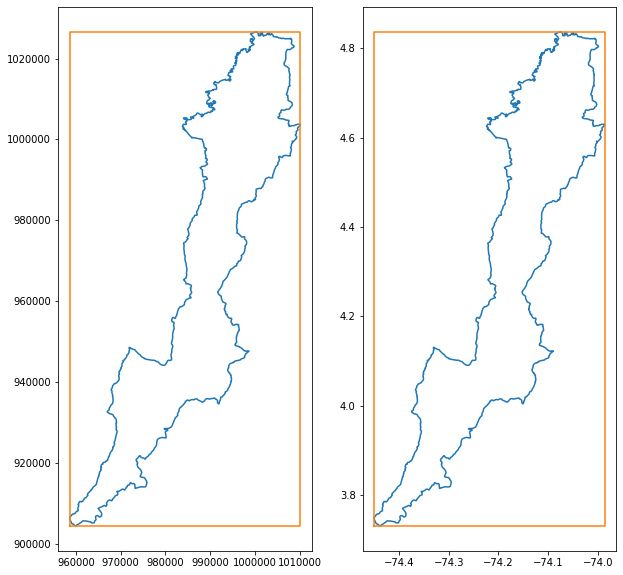

In [45]:
## Validate construction of rectangular region (should bound bogota polygon)
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].plot(*bogota_polygon_metters.exterior.xy)
ax[0].plot(*shapely_rectangular.exterior.xy)
ax[1].plot(*bogota_polygon.exterior.xy)
ax[1].plot(*shapely_rectangular_WGS84.exterior.xy)